In [3]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Turn on autoreload
%load_ext autoreload
%autoreload 2



# Tuning dynamical phases


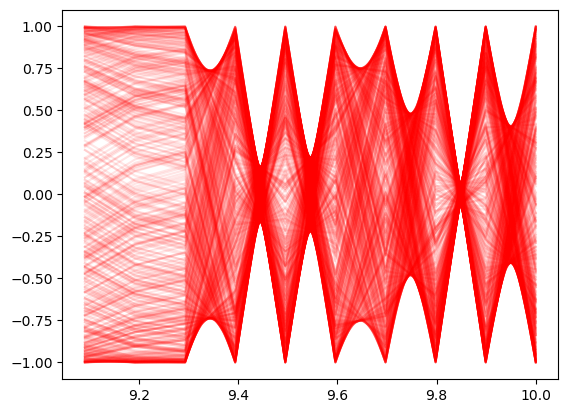

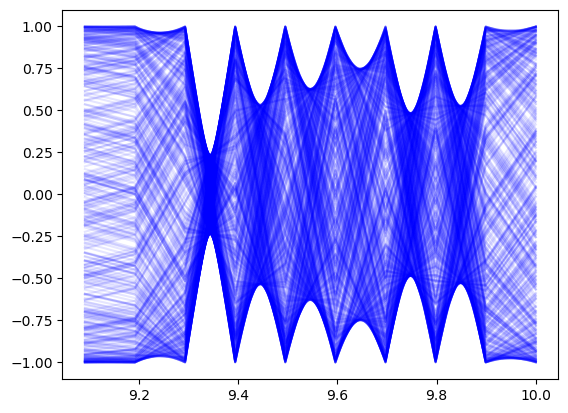

In [30]:
def kuramoto(t, X, n=128, a=0.1, b=0.2):
    alpha = np.pi / 2 - b
    # m + v = 1
    # m - v = a
    u = (1 + a) / 2
    v = (1 - a) / 2
    # print(u, v)
    # return None
    jaa = u * np.ones((n // 2, n // 2))
    jab = v * np.ones((n // 2, n // 2))
    J = np.block([
        [jaa, jab],
        [jab, jaa]
    ])
    
    phase_diffs = X[:, None] - X[None, :]
    dtheta = (1 / (n // 2)) * np.sum(J @ np.sin(phase_diffs - alpha), axis=1)
    return dtheta

## Specify the number of oscillators and their initial conditions
n_oscillators = 1024
initial_conditions = np.random.uniform(0, 2 * np.pi, n_oscillators)

from scipy.integrate import solve_ivp
fsol = solve_ivp(
    kuramoto, [0, 100], 
    initial_conditions, t_eval=np.linspace(0, 10, 100), args=(n_oscillators,))


t = fsol.t
y1, y2 = fsol.y[:n_oscillators//2], fsol.y[n_oscillators//2:]

plt.figure()
plt.plot(t[-10:], np.sin(y1.T)[-10:], 'r', alpha=0.1);

plt.figure()
plt.plot(t[-10:], np.sin(y2.T)[-10:], 'b', alpha=0.1);


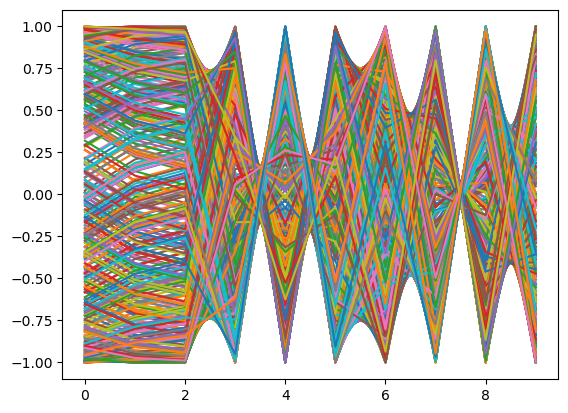

In [33]:
plt.plot(np.sin(y1.T)[-10:])

In [24]:
y1.T.shape

(100, 512)

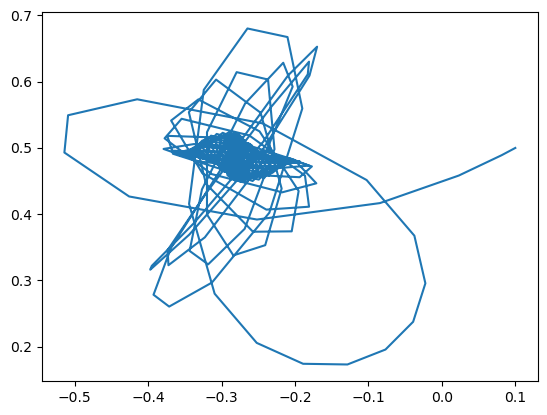

In [4]:
import numpy as np
# from numba import njit


class MagneticPendulum:
    """The magnetic pendulum system.
    
    Parameters:
        omega (float): The angular frequency of the pendulum.
        alpha (float): The damping coefficient.
        h (float): The height of the magnets.
        r_mag (list): The positions of the magnets. A list of 2D vectors.
    
    """
    def __init__(self, omega=0.5, alpha=0.2, h=0.2, 
                 r_mag=[
                     [1/np.sqrt(3), 0], 
                     [-1/(2 * np.sqrt(3)), 1/2],
                     [-1/(2 * np.sqrt(3)), -1/2]
        ]):
        assert len(r_mag) > 0, "The must be at least one magnet."
        self.omega = omega
        self.alpha = alpha
        self.h = h
        self.r_mag = np.array(r_mag).T

        self.J0 = np.zeros((4, 4))
        self.J0[0, 2] = 1.0
        self.J0[1, 3] = 1.0
        self.J0[2:4, 0:2] = 0.0
        self.J0[2, 0] = -omega**2
        self.J0[3, 1] = -omega**2
        self.J0[2, 2] = -alpha
        self.J0[3, 3] = -alpha

    @staticmethod
    def magnet_dist(r, r_m, h):
        return np.sqrt(np.sum((r - r_m)**2) + h**2)

    @staticmethod
    def magnet_force(r, r_m, h):
        d = np.sqrt(np.sum((r - r_m)**2) + h**2)
        return (r_m - r) / d**3
   
    def rhs(self, t, u):
        return self._rhs(t, *u, self.omega, self.alpha, self.h, self.r_mag)

    @staticmethod
    def _rhs(t, x, y, vx, vy, omega, alpha, h, r_mag):

        r = np.array([x, y])
        v = np.array([vx, vy])
        d = np.sqrt(np.sum((r[:, None] - r_mag)**2, axis=0) + h**2)

        mag_force = -omega**2 * r - alpha * v + np.sum((r_mag - r[:, None]) / d**3, axis=-1)
        
        return vx, vy, mag_force[0], mag_force[1]

    def jac(self, t, u):
        return self._jac(t, *u, np.copy(self.J0), u[:2, None], self.omega, self.alpha, self.h, self.r_mag)

    @staticmethod
    def _jac(t, x, y, vx, vy, J0, r, omega, alpha, h, r_mag):
        J = J0
        # r = np.array([x, y])
        # r = r[:, None]
        d = np.sqrt(np.sum((r - r_mag)**2, axis=0) + h**2)
        c1 = 1 / d**3
        c2 = d**5
        c3 = 3 * (r_mag[0] - x) * (r_mag[1] - y) / c2
        c4 = 3 / c2

        J[2, 0] += np.sum(c4 * (r_mag[0] - x)**2 - c1, axis=-1)
        J[2, 1] += np.sum(c3, axis=-1)
        J[3, 0] += np.sum(c3, axis=-1)
        J[3, 1] += np.sum(c4 * (r_mag[1] - y)**2 - c1, axis=-1)

        return J

# given beta we set alpha, a
u = 1 - v
beta = pi/2 - alpha
alpha = pi/2 - beta
A = u - v


ic = np.array([0.1, 0.5, 0.0, 0.0])
from scipy.integrate import solve_ivp

eq = MagneticPendulum()
fsol = solve_ivp(eq.rhs, [0, 100], ic, t_eval=np.linspace(0, 100, 1000), jac=eq.jac, method='Radau', rtol=1e-10, atol=1e-10)
sol = fsol.y.T

plt.plot(sol[:, 0], sol[:, 1])

## A naive approach: the shooting method

# The adjoint method

We now want to derive a functional that encodes a desired behavior. For targeting, our target functional is the difference between the solution $\mathbf{x}(T)$ at some target time $T$, and the desired solution $\mathbf{x}_T$. We define the target functional as

$$
\mathcal{L}(\mathbf{x}(t), \mathbf{x}_T) = \frac{1}{2} \|\mathbf{x}(T) - \mathbf{x}_T\|^2
$$

the location at time $T$ may be written as a function of the initial condition and the parameters of the ODE,

$$
\mathbf{x}(T) = \mathbf{x}(0) + \int_0^T \mathbf{f}_\theta(\mathbf{x}(t), t) dt
$$

where $\mathbf{x}_0$ is the initial condition and $\mathbf{p}$ are the parameters of the ODE. We can summarize this by defining a flow map $\mathbf{\Phi}$ that maps the initial condition and parameters to the solution at time $T$,

$$
\mathbf{x}(T) \equiv \mathbf{\Phi}(\mathbf{x}_0)
$$

We now wish to compute the derivative of the target functional with respect to the initial condition $\mathbf{x}_0$. We can do this by applying the chain rule,

$$
\frac{d\mathcal{L}}{d\mathbf{x}_0} = \frac{d\mathcal{L}}{d\mathbf{x}(T)} \frac{d\mathbf{x}(T)}{d\mathbf{x}_0}
$$

The first term on the right-hand side is simply the gradient of the target functional with respect to the solution at time $T$,

$$
\frac{d\mathcal{L}}{d\mathbf{x}(T)} = \mathbf{x}(T) - \mathbf{x}_T
$$

The second term is the derivative of the flow map with respect to the initial condition,

$$
\frac{d\mathbf{x}(T)}{d\mathbf{x}_0} = \frac{d\mathbf{\Phi}(\mathbf{x}_0)}{d\mathbf{x}_0}
$$

we can compute this derivative by solving the adjoint equation,

$$
\frac{d\mathbf{p}}{dt} = -\left(\frac{\partial \mathbf{f}_\theta}{\partial \mathbf{x}}\right)^T \mathbf{p}
$$

where $\mathbf{p}(T) = \frac{d\mathcal{L}}{d\mathbf{x}(T)}$. The adjoint equation is a backward-in-time ODE that computes the gradient of the target functional with respect to the initial condition. We can now compute the gradient of the target functional with respect to the parameters of the ODE by applying the chain rule,